# Customer activity: analysis report

### Data dictionary for online customer activity

- **administrative**: Columns which indicates which administrative activity the user was performing on their account.
- **administrative_duration**: How long a user performed administrative tasks in that session.
- **informational**: Indicates which informational activity the user was performing on the website.
- **informational_duration**: How long a users performed informational tasks in seconds during that session.
- **product_related**: Indicates which product the user was viewing on the website.
- **product_related_duration**: How long a user browsed products during that session. 
- **bounce_rates**: Historical bounce rate of that particular page for all users. They visited the directly and immediately exited. - This column has been dropped. Heavily correlated with 'exit_rates'.
- **exit_rates**: Historical exit rate of the users from that particular page. 
- **page_values**: The average value contribution of a page to a customer sale
- **month**: Month the users activity took place
- **operating_systems**: Operating system the user was using
- **browser**: The browser used by the user
- **region**: The region the user originated from
- **traffic_type**: How the user was redirected to the site
- **visitor_type**: Whether a customer was is new/returning or other
- **weekend**: Whether the activity only took place during the weekend
- **revenue**: Whether the customer purchased anything that session

In [3]:
from scripts.info_extractor import DataFrameInfo
from scripts.data_formatter import DataFormat
from scripts.transformer import DataTransform
from scripts.plotter import Plotter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
customer_activity_df = pd.read_csv('data/preprocessed_data.csv')
customer_activity_skewed = pd.read_csv('data/preprocessed_skewed_data.csv')
customer_activity_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
formatter = DataFormat(customer_activity_df)
customer_activity_df = formatter.convert_columns(['administrative','informational','product_related'],'int')
customer_activity_df = formatter.convert_columns(['month'],'date')

## Task 1: What are our customers doing?

### ***Are sales proportionally happening more on weekends?***

In [6]:
sales_weekends_df = customer_activity_df.iloc[:,-2:]
weekend_effect = sales_weekends_df.groupby(['weekend']).sum()
total_sales = sales_weekends_df['revenue'].sum()
print(total_sales)
weekend_effect['proportion_sales_percentage'] = (weekend_effect['revenue']/total_sales) * 100
weekend_effect.head()

1896


,revenue,proportion_sales_percentage
weekend,,
0,1465,77.267932
1,431,22.732068


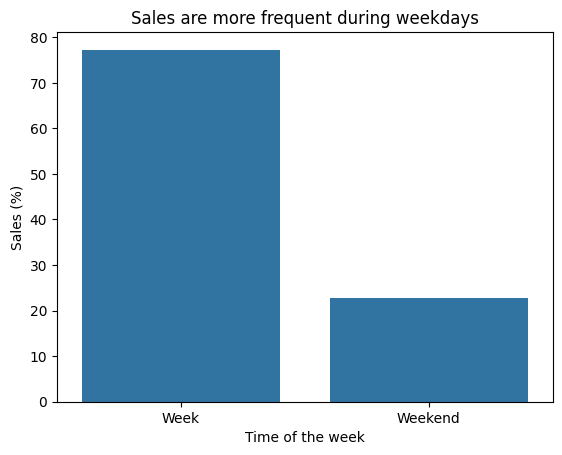

In [7]:
sns.barplot(x=weekend_effect.index, y=weekend_effect['proportion_sales_percentage'])
new_labels = ['Week', 'Weekend']
plt.xticks(range(len(new_labels)), new_labels)
plt.title('Sales are more frequent during weekdays')
plt.xlabel('Time of the week')
plt.ylabel('Sales (%)')
plt.show()

### ***Which regions are generating the most revenue currently?***

In [8]:
# NOTE would just order this table

info_extractor = DataFrameInfo(customer_activity_df)
region_sales = info_extractor.get_slice(['region','revenue'])
region_sales = region_sales.groupby(['region'],as_index=False).sum()
region_sales

,region,revenue
0,Africa,130
1,Asia,187
2,Eastern Europe,194
3,North America,750
4,Northern Africa,82
5,Oceania,51
6,South America,130
7,Southern Africa,49
8,Western Europe,323


In [9]:
region_sales.at[4,'region'] = 'Africa'
region_sales.at[7,'region'] = 'Africa'
region_sales = region_sales.groupby(['region']).sum()
region_sales['proportion_sales_percentage'] = (region_sales['revenue']/total_sales) * 100
region_sales

,revenue,proportion_sales_percentage
region,,
Africa,261,13.765823
Asia,187,9.862869
Eastern Europe,194,10.232068
North America,750,39.556962
Oceania,51,2.689873
South America,130,6.856540
Western Europe,323,17.035865


/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/742427083.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rs = sns.barplot(x=region_sales.index, y=region_sales['proportion_sales_percentage'], order=order, palette='hls')
/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/742427083.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rs.set_xticklabels(rs.get_xticklabels(), rotation=90)


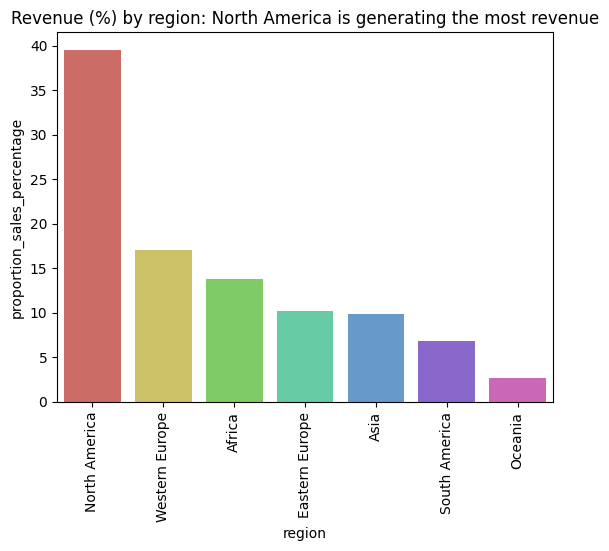

In [10]:
order = region_sales.sort_values(by='proportion_sales_percentage', ascending=False).index
rs = sns.barplot(x=region_sales.index, y=region_sales['proportion_sales_percentage'], order=order, palette='hls')
plt.title('Revenue (%) by region: North America is generating the most revenue')
rs.set_xticklabels(rs.get_xticklabels(), rotation=90)
plt.show()

### ***Is there any particular website traffic that stands out when generating sales?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/2208992666.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  wt.set_xticklabels(wt.get_xticklabels(), rotation=90)


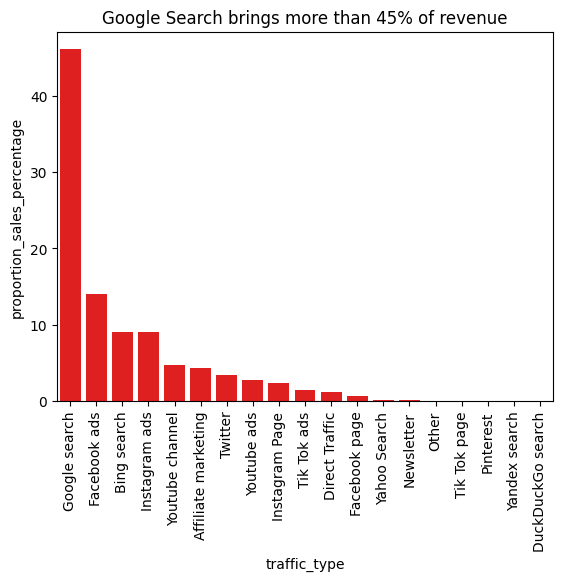

In [11]:
website_traffic = info_extractor.get_slice(['traffic_type','revenue'])
website_traffic = website_traffic.groupby(['traffic_type']).sum()
website_traffic['proportion_sales_percentage'] = (website_traffic['revenue']/total_sales) * 100
order_w = website_traffic.sort_values(by='proportion_sales_percentage', ascending=False).index
wt = sns.barplot(x=website_traffic.index, y=website_traffic['proportion_sales_percentage'], order =order_w, color='r')
plt.title('Google Search brings more than 45% of revenue')
wt.set_xticklabels(wt.get_xticklabels(), rotation=90)
plt.show()

### ***What percentage of time is spent on the website performing administrative/product or informational related tasks?***

In [12]:
info_extractor_2 = DataFrameInfo(customer_activity_skewed)
admin_task = info_extractor_2.get_slice(['administrative','administrative_duration'])
product_related_task = info_extractor_2.get_slice(['product_related','product_related_duration'])
informational_task = info_extractor_2.get_slice(['informational','informational_duration'])
combined = info_extractor_2.get_slice(['administrative_duration','informational_duration','product_related_duration'])

In [13]:
# For our purpose, we are going to drop all records where time = 0 for all three task types simultaneously 
combined_filtered = combined[~((combined['administrative_duration'] == 0) & (combined['informational_duration'] == 0) & (combined['product_related_duration'] == 0))]

In [14]:
task_times = combined_filtered.copy()
task_times['total_time_per_visit'] = task_times['administrative_duration'] + task_times['informational_duration'] + task_times['product_related_duration']
task_times['admin_time_%'] = (task_times['administrative_duration'] / task_times['total_time_per_visit']) * 100
task_times['info_time_%'] = (task_times['informational_duration'] / task_times['total_time_per_visit']) * 100
task_times['product_time_%'] = (task_times['product_related_duration'] / task_times['total_time_per_visit']) * 100


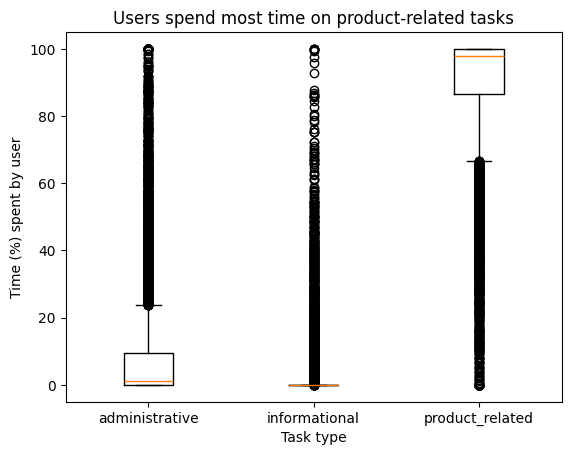

In [15]:
# TODO Would also get the count of the amount of tasks per segment and total time spent

labels=['administrative', 'informational', 'product_related']
plt.boxplot([task_times['admin_time_%'], task_times['info_time_%'], task_times['product_time_%']], labels=labels )
plt.xlabel('Task type')
plt.ylabel('Time (%) spent by user')
plt.title('Users spend most time on product-related tasks')
plt.show()

### ***Are there any informational/administrative tasks which users spend time doing most?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/3622874086.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  at.set_xticklabels(at.get_xticklabels(), rotation=90)


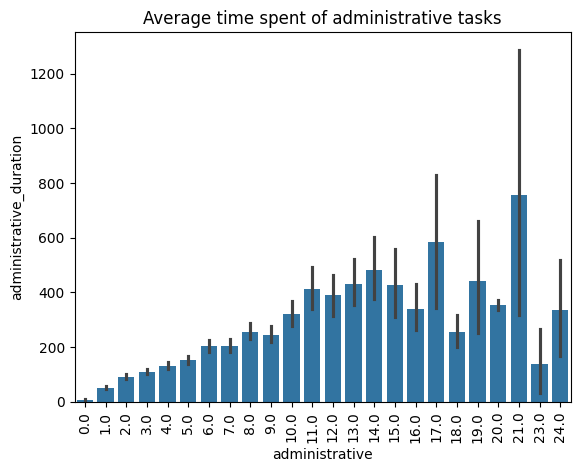

In [16]:
at = sns.barplot(data=admin_task, y="administrative_duration", x="administrative")
plt.title('Average time spent of administrative tasks')
at.set_xticklabels(at.get_xticklabels(), rotation=90)
plt.show()

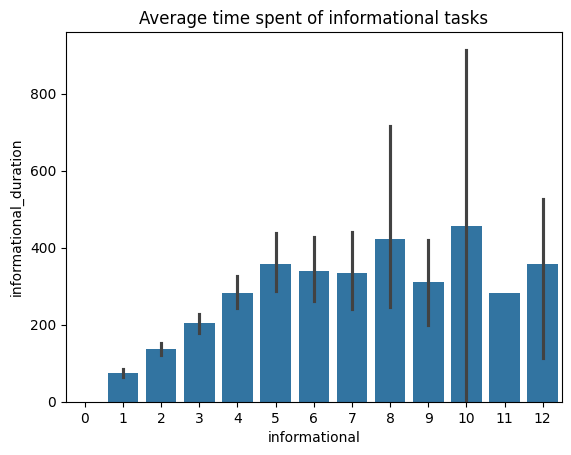

In [17]:
sns.barplot(data=informational_task, y="informational_duration", x="informational")
plt.title('Average time spent of informational tasks')
plt.show()

### ***What is the breakdown of months making the most sales?***

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/3444113601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_sales['month'] = month_sales['month'].dt.month
/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/3444113601.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_sales.index, y=month_sales['proportion_sales_percentage'],palette=cols)


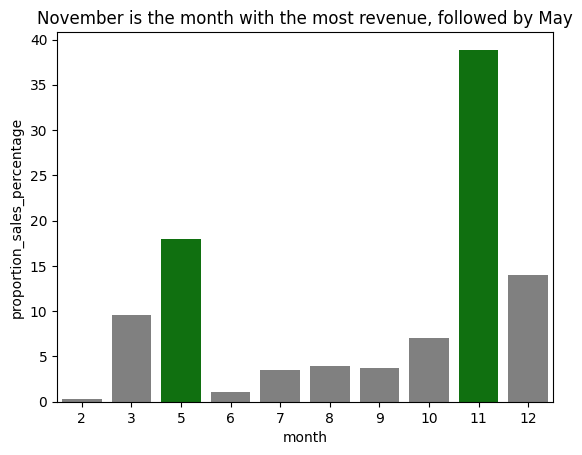

In [18]:
# Love the highlighting of the columns here great job 

month_sales = info_extractor.get_slice(['month','revenue'])
month_sales['month'] = month_sales['month'].dt.month
month_sales = month_sales.groupby(['month']).sum()
month_sales['proportion_sales_percentage'] = (month_sales['revenue']/total_sales) * 100
cols = ['grey' if x < 15 else 'green' for x in month_sales.proportion_sales_percentage]
sns.barplot(x=month_sales.index, y=month_sales['proportion_sales_percentage'],palette=cols)
plt.title('November is the month with the most revenue, followed by May')
plt.show()


## Task 2: What ***software*** are our customers using the most to access the website?

### ***The count of the operating systems used to visit the site and the percentage of the total***

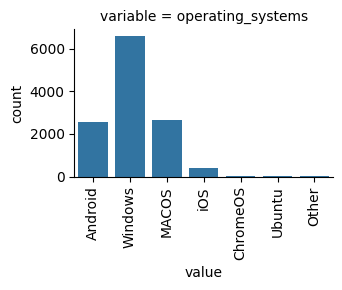

In [19]:
plotter = Plotter(customer_activity_df)
plotter.count_plots_grid(['operating_systems'])

In [20]:
total_entries = len(customer_activity_df['operating_systems'])
os_counts = customer_activity_df.copy()
info_extractor_3 = DataFrameInfo(os_counts)
os_counts = info_extractor_3.get_slice(["operating_systems"])
os_counts['counts'] = 1
os_counts = os_counts.groupby(['operating_systems']).sum()
os_counts["count_%"] = (os_counts['counts'] / total_entries) * 100
os_counts

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/1370675072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  os_counts['counts'] = 1


,counts,count_%
operating_systems,,
Android,2579,21.056499
ChromeOS,25,0.204115
MACOS,2671,21.807642
Other,7,0.057152
Ubuntu,9,0.073481
Windows,6572,53.657740
iOS,385,3.143370


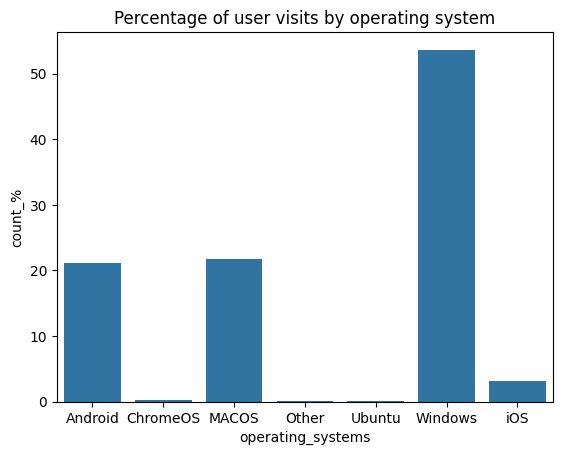

In [21]:
sns.barplot(x=os_counts.index, y=os_counts['count_%'])
plt.title('Percentage of user visits by operating system')
plt.show()

### ***The amount of users visiting the site using mobile operating system and desktop operating systems***

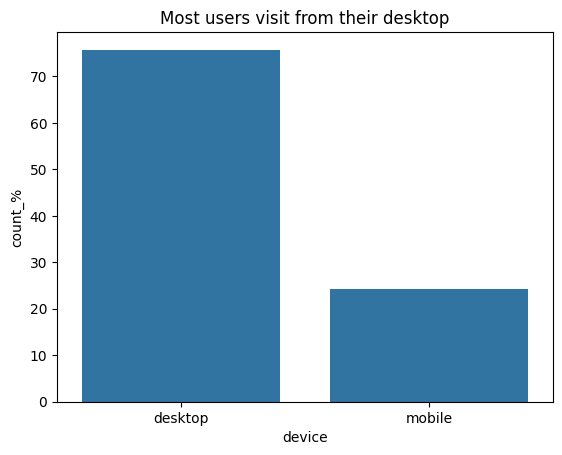

In [22]:
# NOTE Would get exact figures for this as well

# Add column for device type (mobile or desktop) and drop outliers in operating systems ('Other')
map_dev = {'Android':'mobile', 'iOS':'mobile', 'MACOS': 'desktop','ChromeOS':'desktop','Windows':'desktop','Ubuntu':'desktop'}
device_df = os_counts.copy()
device_df['device'] = device_df.index.map(map_dev)
device_df.dropna(subset='device', inplace=True)
device_df_grouped = device_df.groupby(['device']).sum().reset_index()
sns.barplot(x=device_df_grouped['device'], y=device_df_grouped['count_%'])
plt.title('Most users visit from their desktop')
plt.show()

### ***The most commonly used browsers and their breakdown on mobile versus desktop***

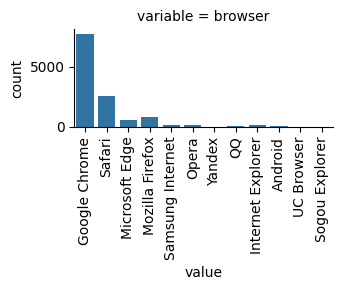

In [23]:
plotter.count_plots_grid(['browser'])
#sns.catplot(x='class', y='survival rate', hue='sex', data=dfm, kind='bar', height=5, aspect=1)

In [24]:
browser_device_region = customer_activity_df.copy()
browser_device_region['device'] = browser_device_region['operating_systems'].map(map_dev)
browser_device_region.dropna(subset='device', inplace=True)
browser_device_region['counts'] = 1
info_extractor = DataFrameInfo(browser_device_region)
browser_device_region =  info_extractor.get_slice(['operating_systems','browser','region','device','counts'])
browser_device_region = browser_device_region[browser_device_region['browser'] != 'Yandex']
browser_device_region = browser_device_region[browser_device_region['browser'] != 'UC Browser']
browser_device_region = browser_device_region[browser_device_region['browser'] != 'Sogou Explorer']

In [25]:
browser_device = browser_device_region.groupby(['browser','device']).sum(['counts'])
browser_device['counts_%'] = (browser_device['counts']/total_entries)*100

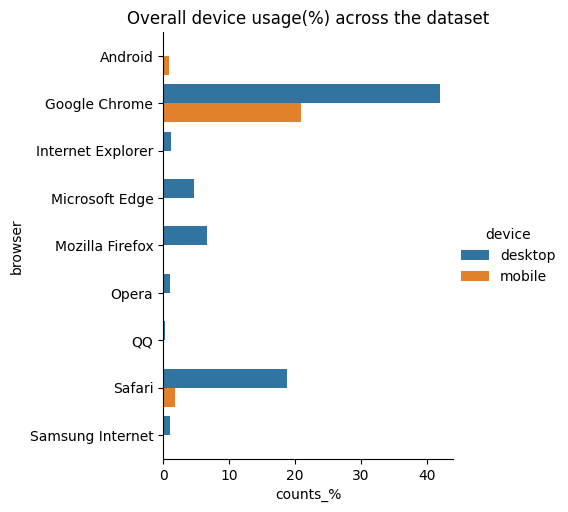

In [26]:
# TODO Seems to be an error finding the browser column here

sns.catplot(y='browser', x='counts_%', hue='device', data=browser_device, kind='bar', height=5, aspect=1)
plt.title('Overall device usage(%) across the dataset')
plt.show()

In [27]:
browser_dev_df2 = browser_device_region.groupby(['browser']).sum(['counts'])
browser_dev_df2.rename(columns={"counts":"counts_per_browser"},inplace=True)
browser_device = browser_device.join(browser_dev_df2)
browser_device["counts_%_relative"] = (browser_device["counts"] / browser_device['counts_per_browser']) * 100

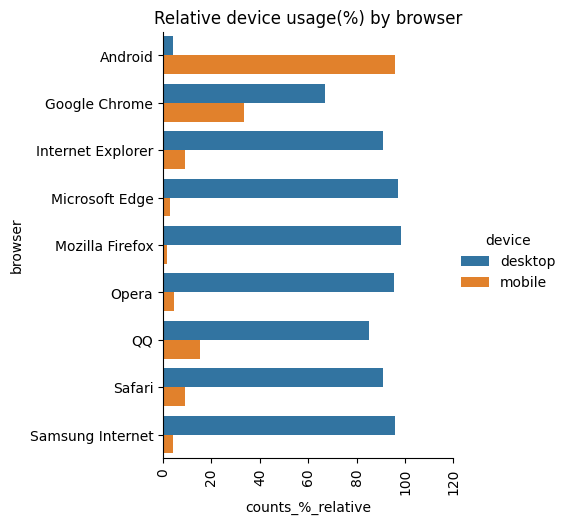

In [28]:
g = sns.catplot(y='browser', x='counts_%_relative', hue='device', data=browser_device, kind='bar', height=5, aspect=1)
g.set_xticklabels(rotation=90)
plt.title('Relative device usage(%) by browser')
plt.show()

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/1982491081.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Relative device usage(%) by browser')

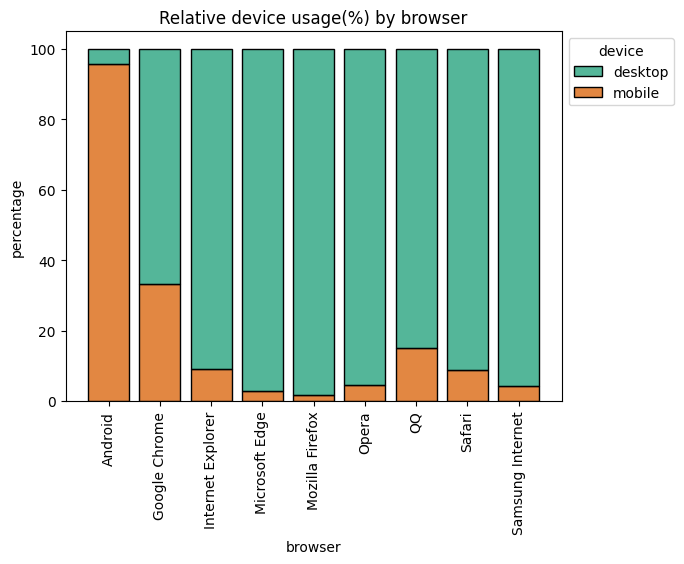

In [29]:
ax4 = sns.histplot(browser_device, x='browser', hue='device', weights='counts_%_relative',
             multiple='stack', palette='Dark2', shrink=0.8)
ax4.set_ylabel('percentage')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)
# Fix the legend so it's not on top of the bars.
legend = ax4.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.title('Relative device usage(%) by browser')

### Based on this analysis of what are the most popular operating systems, ***are there any regions where there is a discrepancy in what is popular?*** 

This could be an indication that users in that region are having technical issues that the tech team might want to investigate.

In [30]:
os_region = browser_device_region.copy()
map_reg = {'Africa':'Africa','Northern Africa':'Africa','Southern Africa':'Africa', 'Oceania': 'Oceania', 'Eastern Europe': 'Eastern Europe','Western Europe': 'Western Europe','Asia':'Asia','North America':'North America', 'South America':'South America'}
os_region['region'] = os_region['region'].map(map_reg)
os_region_df1 = os_region.groupby(['region', 'operating_systems']).sum(['counts'])
os_region_df1['counts_%'] = (os_region_df1['counts']/total_entries)*100                                                                    

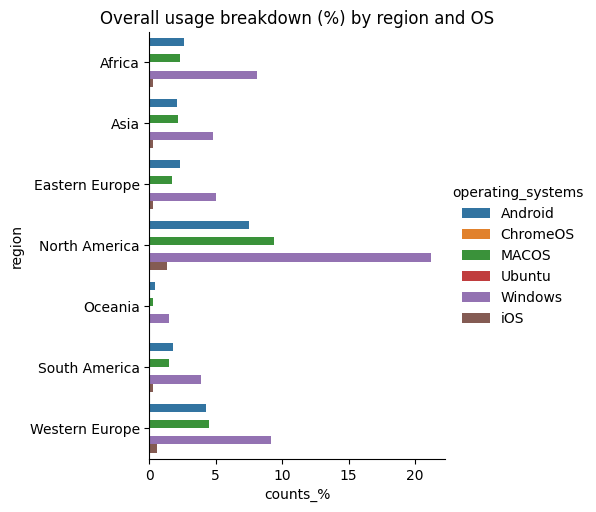

In [31]:
sns.catplot(y='region', x='counts_%', hue='operating_systems', data=os_region_df1, kind='bar')
plt.title('Overall usage breakdown (%) by region and OS')
plt.show()

In [32]:
os_region_df2 = os_region.groupby(['region']).sum(['counts'])
os_region_df2.rename(columns={"counts":"counts_per_region"},inplace=True)
os_region_df2 = os_region_df1.join(os_region_df2)
os_region_df2["counts_%_relative"] = (os_region_df2["counts"] / os_region_df2['counts_per_region']) * 100

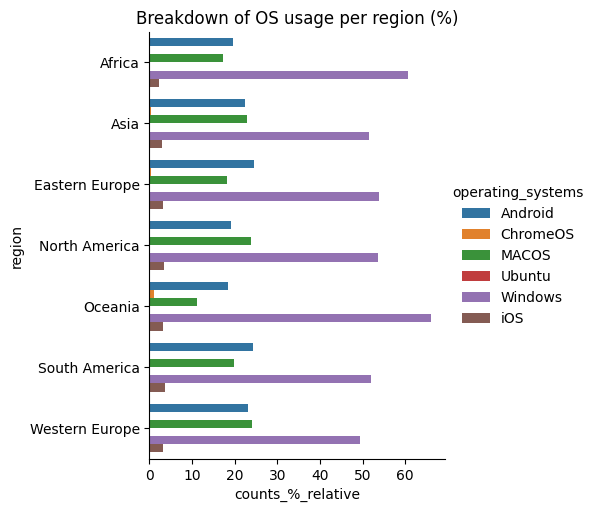

In [33]:
sns.catplot(y='region', x='counts_%_relative', hue='operating_systems', data=os_region_df2, kind='bar')
plt.title('Breakdown of OS usage per region (%)')
plt.show()

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/3361108063.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)


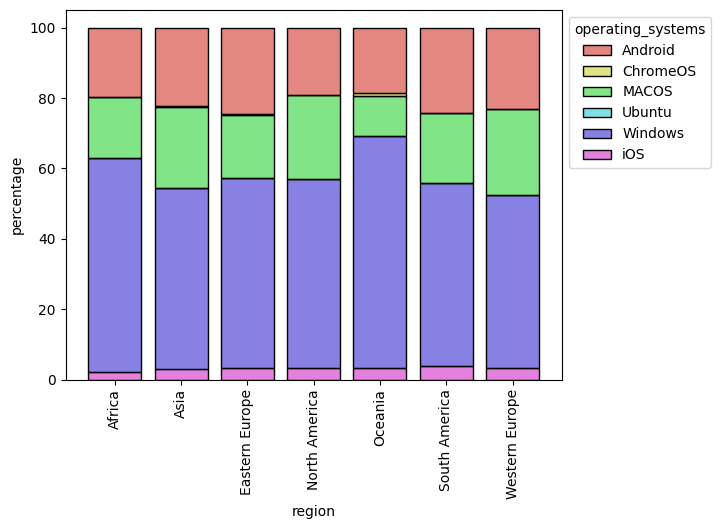

In [34]:
ax3 = sns.histplot(os_region_df2, x='region', hue='operating_systems', weights='counts_%_relative',
             multiple='stack', palette='hls', shrink=0.8)
ax3.set_ylabel('percentage')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90)
# Fix the legend so it's not on top of the bars.
legend = ax3.get_legend()
legend.set_bbox_to_anchor((1, 1))

## Task 3: Do we need to optimise our marketing strategy?

### ***What traffic is currently generating the most revenue, broken down by region?***

In [35]:
df1 = customer_activity_df.copy()
info_extractor_4 = DataFrameInfo(df1)
df1 = info_extractor_4.get_slice(['traffic_type','region','revenue'])
df1['region'] = df1['region'].map(map_reg)
exclude_traffic_types = ['Yandex search', 'DuckDuckGo search', 'Other', 'Tik Tok page']
df1 = df1[~df1['traffic_type'].isin(exclude_traffic_types)]
df2 = df1.groupby(['traffic_type','region']).sum() 
total_revenue = df2['revenue'].sum()
df2['%_total_revenue'] = (df2['revenue']/total_revenue)*100           

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/969934840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['region'] = df1['region'].map(map_reg)


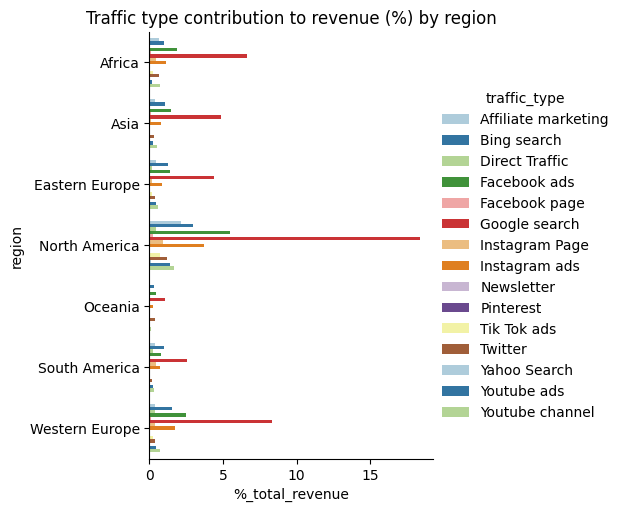

In [36]:
sns.catplot(y='region', x='%_total_revenue', hue='traffic_type', data=df2, kind='bar', palette='Paired')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

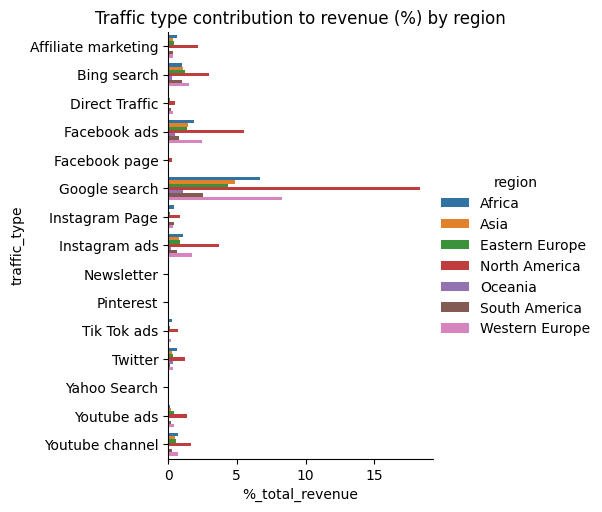

In [37]:
sns.catplot(y='traffic_type', x='%_total_revenue', hue='region', data=df2, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

In [38]:
df3 = df1.groupby(['region']).sum()
df3.rename(columns={"revenue":"revenue_by_region"},inplace=True)
del df3['traffic_type']
df4 = df1.groupby(['region','traffic_type']).sum() 
df3 = df4.join(df3)
df3["revenues_%_relative"] = (df3["revenue"] / df3['revenue_by_region']) * 100

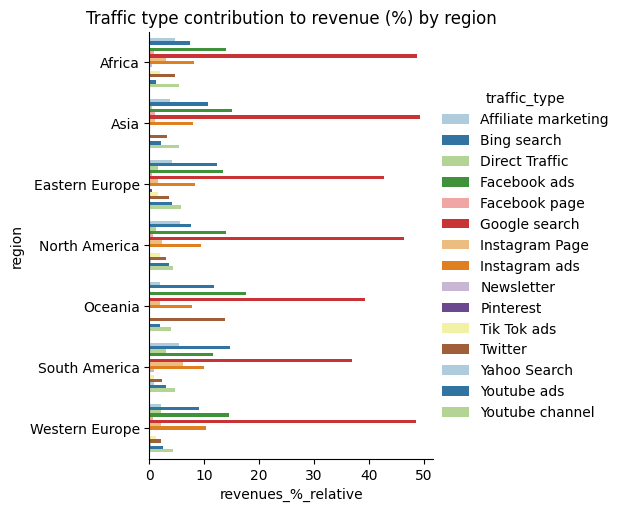

In [39]:
sns.catplot(y='region', x='revenues_%_relative', hue='traffic_type', data=df3, kind='bar', palette='Paired')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/3433374329.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


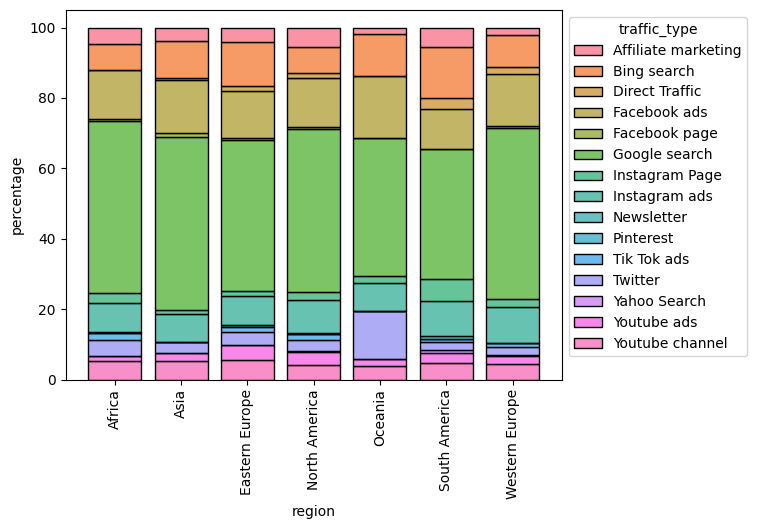

In [40]:
ax2 = sns.histplot(df3, x='region', hue='traffic_type', weights='revenues_%_relative',
             multiple='stack', shrink=0.8)
ax2.set_ylabel('percentage')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
# Fix the legend so it's not on top of the bars.
legend = ax2.get_legend()
legend.set_bbox_to_anchor((1, 1))

In [41]:
df5 = df1.groupby(['traffic_type']).sum()
df5.rename(columns={"revenue":"revenue_by_traffic_type"},inplace=True)
del df5['region']
df5 = df2.join(df5)
df5["revenues_%_relative"] = (df5["revenue"] / df5['revenue_by_traffic_type']) * 100

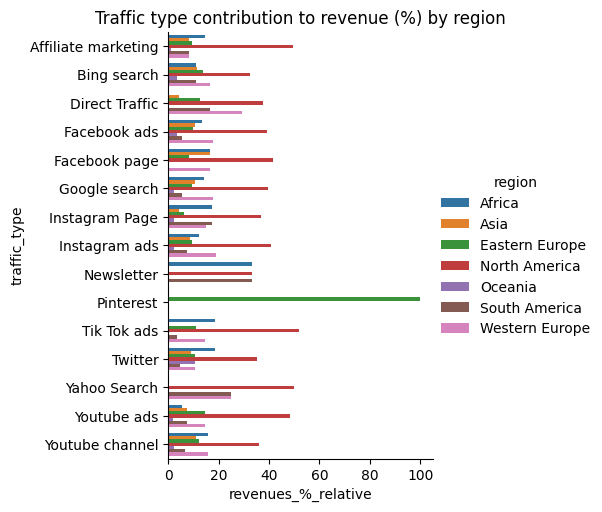

In [42]:
sns.catplot(y='traffic_type', x='revenues_%_relative', hue='region', data=df5, kind='bar')
plt.title('Traffic type contribution to revenue (%) by region')
plt.show()

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/2928727587.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


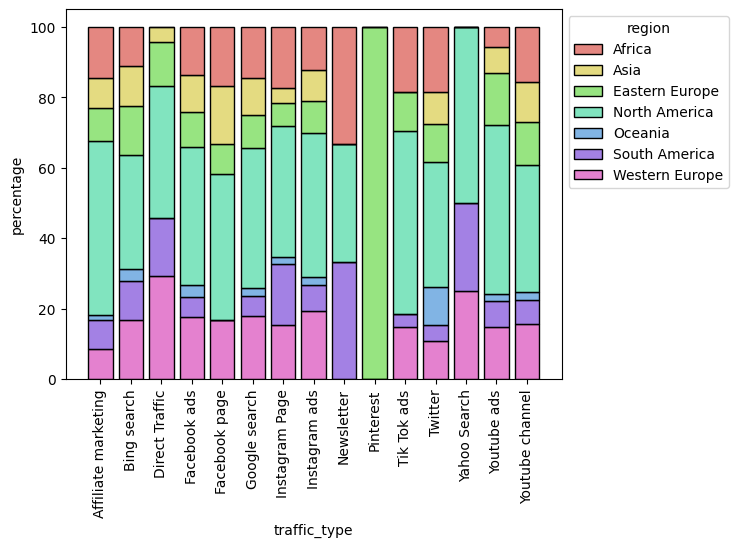

In [43]:
ax = sns.histplot(df5, x='traffic_type', hue='region', weights='revenues_%_relative',
             multiple='stack', palette='hls', shrink=0.8)
ax.set_ylabel('percentage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

### ***What traffic has the highest bounce rate?***

This could indicate that the marketing channels advertisement isn't enticing enough - for the customers. Conversely a low bounce rate can indicate that the strategy is highly effective. Break down this data by region.

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/2971967955.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  brd.set_xticklabels(brd.get_xticklabels(), rotation=90)


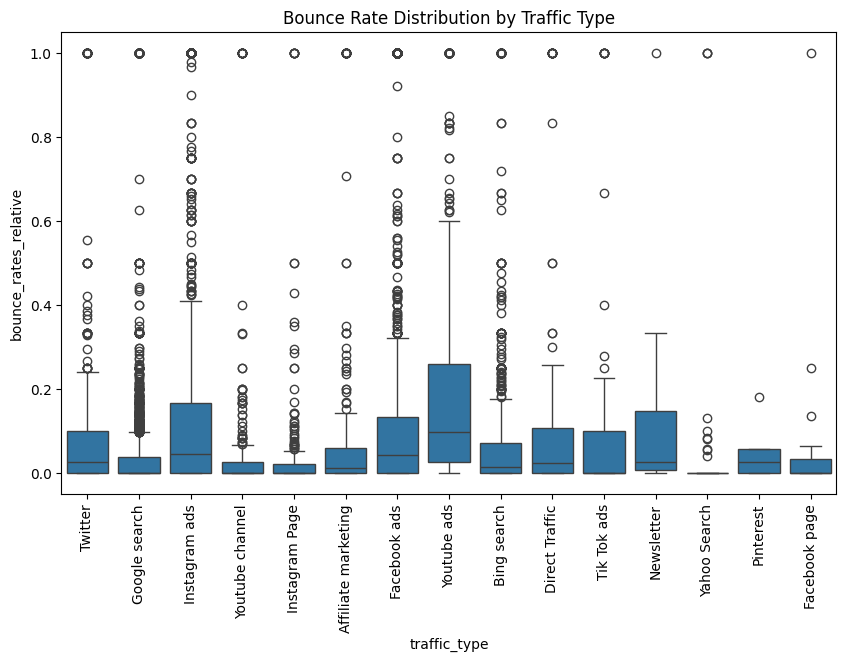

In [44]:
# TODO I would also get a count of these bounce rates for each region with a bar graph

info_extractor =  DataFrameInfo(customer_activity_skewed)
bounce_rates_df = info_extractor.get_slice(['bounce_rates','traffic_type','region'])
exclude_traffic_types = ['Yandex search', 'DuckDuckGo search', 'Other', 'Tik Tok page']
bounce_rates_df = bounce_rates_df[~bounce_rates_df['traffic_type'].isin(exclude_traffic_types)]
bounce_rates_df['bounce_rates_relative'] = (bounce_rates_df['bounce_rates']/0.2)
bounce_rates_df['region'] = bounce_rates_df['region'].map(map_reg)

plt.figure(figsize=(10, 6))
brd = sns.boxplot(x='traffic_type', y='bounce_rates_relative', data=bounce_rates_df)
brd.set_xticklabels(brd.get_xticklabels(), rotation=90)
plt.title('Bounce Rate Distribution by Traffic Type')
plt.show()

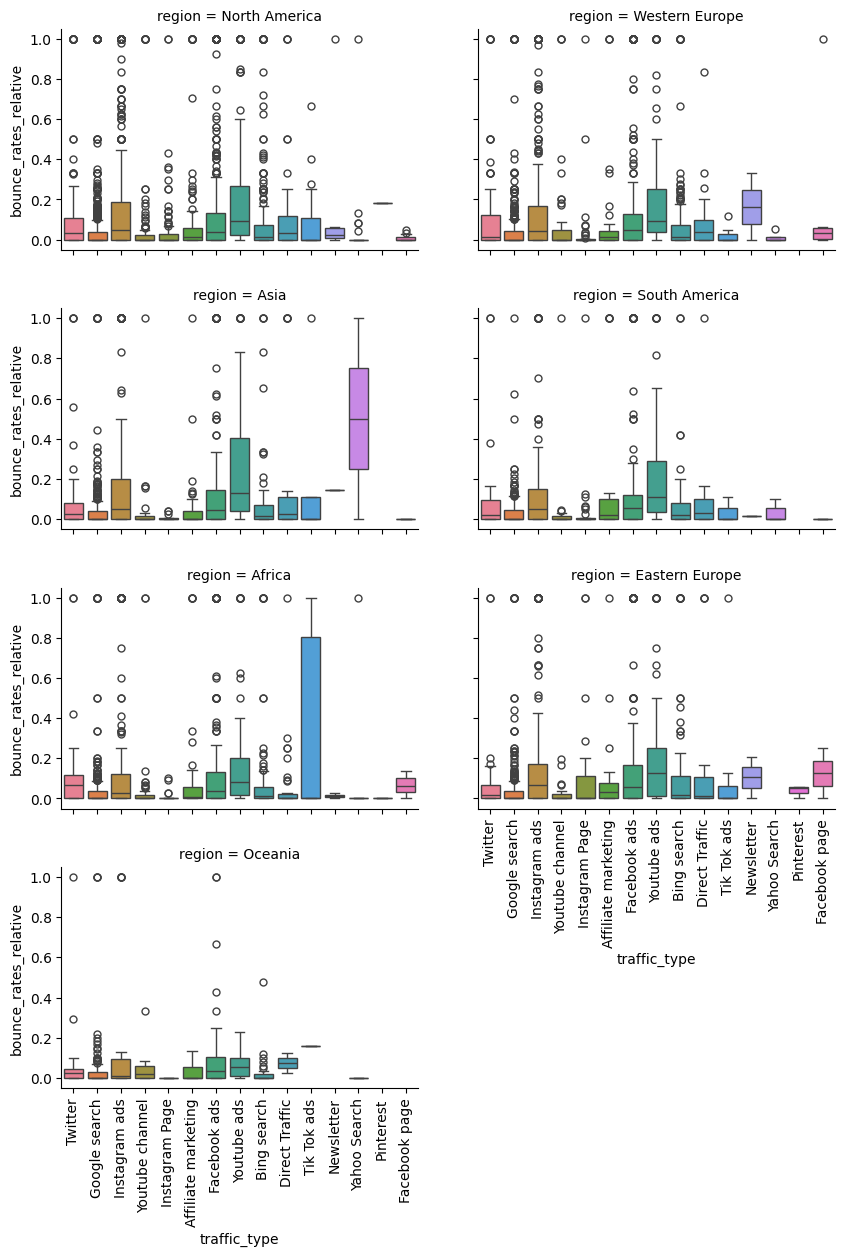

In [45]:
g = sns.catplot(data=bounce_rates_df, col='region', x='traffic_type', y='bounce_rates_relative', kind='box', hue = 'traffic_type', col_wrap=2, height=3, aspect=1, legend=False)
plt.tight_layout(rect=[0, 0, 1.5, 0.96])
g.set_xticklabels(brd.get_xticklabels(), rotation=90)
plt.show()

### ***What months have generated the most sales from ads traffic?***

In [46]:
ads_traffic = ['Facebook ads','Instagram ads','Tik Tok ads','Youtube ads']
 # Filter dataset for records only containing elements in the list above
month_ads = customer_activity_df.copy()
total_revenue = month_ads['revenue'].sum()
month_ads = month_ads.loc[month_ads['traffic_type'].isin(ads_traffic)]
month_ads['month'] = month_ads['month'].dt.month
month_ads_1 = month_ads.groupby(['month']).sum()
month_ads_1['proportion_sales_percentage'] = (month_ads_1['revenue']/total_revenue) * 100

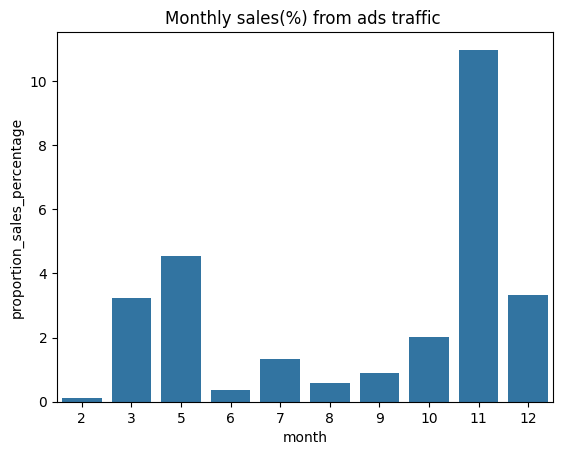

In [47]:
sns.barplot(x=month_ads_1.index, y=month_ads_1['proportion_sales_percentage'])
plt.title('Monthly sales(%) from ads traffic ')
plt.show()

In [48]:
month_ads_2 = month_ads.groupby(['month','traffic_type']).sum()
month_ads_2['proportion_sales_percentage'] = (month_ads_2['revenue']/total_revenue) * 100

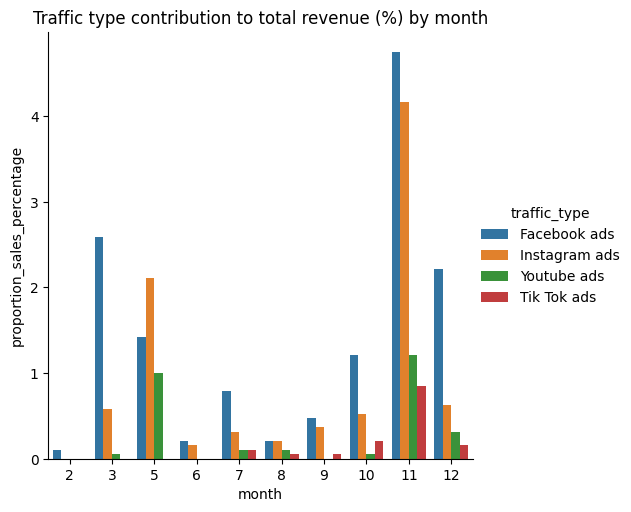

In [49]:
sns.catplot(x='month', y='proportion_sales_percentage', hue='traffic_type', data=month_ads_2, kind='bar')
plt.title('Traffic type contribution to total revenue (%) by month')
plt.show()

## Task 4

### ***Which region is currently generating the most/least revenue?*** Already answered

### ***What percentage of our returning/new customers are making a purchase when they visit the site?***

First we are going to calculate the percentage of new visitors out of the total amount of new visitors that are making a purchase. Then we will perform the same analysis on returning visitors, and plot the results for both in a barplot.

In [50]:
visitor_df = customer_activity_df.copy()
counts_visitors = pd.DataFrame(visitor_df['visitor_type'].value_counts())
info_extractor = DataFrameInfo(visitor_df)
visitor_df2 = info_extractor.get_slice(['visitor_type','revenue'])
visitor_df2 = visitor_df2.groupby(['visitor_type']).sum()
visitor_df2 = visitor_df2.join(counts_visitors)
visitor_df2['purchase_%'] = (visitor_df2['revenue'] / visitor_df2['count'])*100

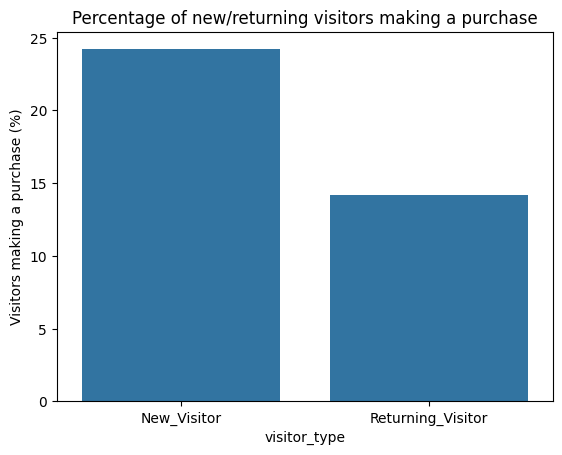

In [51]:
sns.barplot(x=visitor_df2.index, y=visitor_df2['purchase_%'])
plt.title('Percentage of new/returning visitors making a purchase')
plt.ylabel('Visitors making a purchase (%)')
plt.show()

### Takeaway:
- Out of all new visitors, 24% are making a purchase
- Out of all returning visitors, 14% are making a purchase

### Now we are going to visualise the percentage of total revenue coming from each visitor type

In [52]:
visitor_df2['overall_%'] = (visitor_df2['revenue'] / total_sales)*100

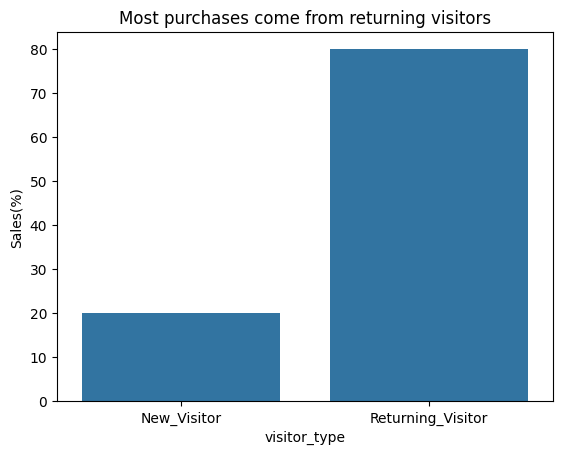

In [53]:
sns.barplot(x=visitor_df2.index, y=visitor_df2['overall_%'])
plt.title('Most purchases come from returning visitors')
plt.ylabel('Sales(%)')
plt.show()

This is explained because the number of returning visitors in our dataset is 10x larger than the number of new visitors.

### ***Are sales being made more on weekends comparatively to weekdays?*** 

Beforehand, we have analysed the percentage of total sales being made on weekdays vs. weekends, as a percentage of the total amount of sales. Here I will breaksdown what percentage of weekend visitors and what percentage of weekday visitors make sales, respectively. Each percentage will be calculated out of the total weekend or weekday visitors.

In [54]:
sales_weekends_df['counts'] = 1
week_time = sales_weekends_df.groupby(['weekend']).sum()
week_time['percentage_sales_over_visitors'] = (week_time['revenue']/week_time['counts'])*100
week_time

,revenue,counts,percentage_sales_over_visitors
weekend,,,
0,1465,9709,15.089093
1,431,2539,16.975187


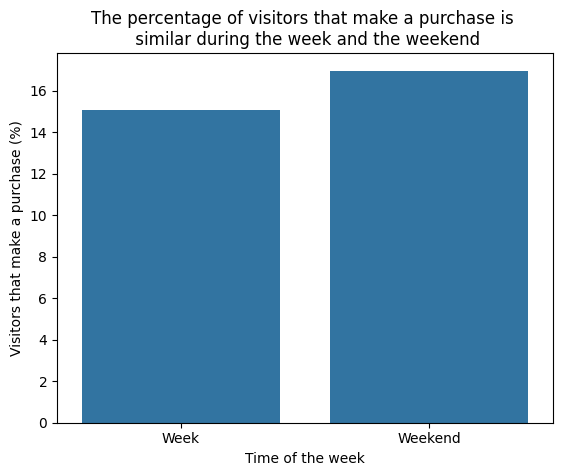

In [55]:
sns.barplot(x=week_time.index, y=week_time['percentage_sales_over_visitors'])
plt.title('The percentage of visitors that make a purchase is \n similar during the week and the weekend')
new_labels = ['Week', 'Weekend']
plt.xticks(range(len(new_labels)), new_labels)
plt.xlabel('Time of the week')
plt.ylabel('Visitors that make a purchase (%)')
plt.show()

### ***Which months have been the most effective for generating sales?*** Already answered

### ***Is direct/social or advertising traffic contributing heavily to sales?***

In [56]:
direct_traffic = 'Direct Traffic'
search_traffic = ['Bing search','Google search','Yahoo search']
all_traffic = df1['traffic_type'].unique()
social_traffic = [i for i in all_traffic if (i not in direct_traffic) & (i not in search_traffic)]
df1['traffic_category'] = ''
for index, row in df1.iterrows():
    traffic_value = row['traffic_type']
    if traffic_value in direct_traffic:
        df1.at[index, 'traffic_category'] = 'Direct Traffic'
    elif traffic_value in search_traffic:
        df1.at[index, 'traffic_category'] = 'Search Traffic'
    elif traffic_value in ads_traffic:
        df1.at[index, 'traffic_category'] = 'Ads Traffic'
    elif traffic_value in social_traffic:
        df1.at[index, 'traffic_category'] = 'Social Traffic'

traffic_cat_df = df1.groupby(['traffic_category']).sum()
total_rev = traffic_cat_df['revenue'].sum()
traffic_cat_df['revenue_%'] = (traffic_cat_df['revenue']/total_rev)*100

/var/folders/1t/k9kg2zvn4r75ygn3223s7x080000gn/T/ipykernel_47954/1323794378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=traffic_cat_df['revenue_%'], x=traffic_cat_df.index, palette=cols2)


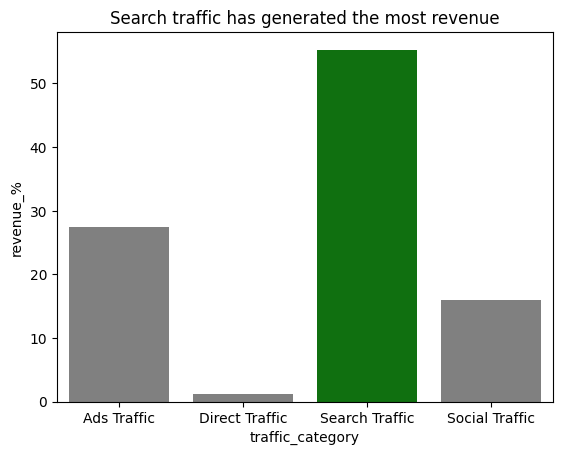

In [57]:
cols2 = ['grey' if x < 50 else 'green' for x in traffic_cat_df['revenue_%']]
sns.barplot(y=traffic_cat_df['revenue_%'], x=traffic_cat_df.index, palette=cols2)
plt.title('Search traffic has generated the most revenue')
plt.show()